# Ejercicio.

En la carpeta datos/sucursales del repositorio se encuentran 2 archivos, un catálogo de todos los municipios del país obtenido a partir de los códigos postales y un archivo con el número de sucursales de cada banco por municipio.

Realizar un breve EDA (Exploratory Data Analysis) para entender los datos.
Obtener:

- Número de municipios en el país
- Número de unicipios que tienen sucursales

- Los 3 bancos con mayor número de sucursales
- Los 3 bancos con menor número de sucursales.

- Los 3 bancos con presencia en mayor número de municipios.

1 ¿Qué banco es el que ayuda a que haya mayor inclusión financiera en el país?, es ecir, el banco que tiene sucursales en municipios donde otros no.

Por facilidad considerar lo siguiente, los municipios con una sola sucursal indican presencia de un solo banco ahí. Obtener los 3 principales bancos que cumplen esto. ¿Hay algo que puedas identificar de estos municipios?

2 Obtener distintas medidas de centralidad para cada banco.
¿Qué métrica elegirías para reforzar tus hallazgos de la pregunta anterior?

In [75]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

import os
from itertools import combinations

In [2]:
data_path = '../data/'

In [3]:
os.path.join(data_path,'catalogo_municipios_sepomex.xlsx')

'../data/catalogo_municipios_sepomex.xlsx'

## 1. Datos

In [4]:
xl_file = pd.ExcelFile(os.path.join(data_path,'catalogo_municipios_sepomex.xlsx'),engine='openpyxl')

df_catalogo_municipios = xl_file.parse('Municipios')

xl_file1 = pd.ExcelFile(os.path.join(data_path,'sucursales_por_municipio.xlsx'),engine='openpyxl')

df_sucursales = xl_file1.parse('Sucursales')

## 2. EDA (Analisis exploratorio de los datos)

###### Shapes y value_counts

In [5]:
df_sucursales.sample(5)

,CVE_PERIODO,CVE_INSTITUCION,DESC_INSTITUCION,CVE_EDO,DESC_EDO,DESC_MUN,LLAVE,NUM_SUCURSALES
144,202004,40002,Banamex,17,Morelos,Puente de Ixtla,Morelos_Puente de Ixtla,1
2177,202004,40072,Banorte,19,Nuevo León,Ciénega de Flores,Nuevo León_Ciénega de Flores,1
3521,202004,40132,Multiva,21,Puebla,Puebla,Puebla_Puebla,3
2008,202004,40072,Banorte,5,Coahuila de Zaragoza,Monclova,Coahuila de Zaragoza_Monclova,4
1274,202004,40021,HSBC,26,Sonora,Hermosillo,Sonora_Hermosillo,12


In [6]:
df_sucursales.DESC_INSTITUCION.value_counts(1)

Banco Azteca             0.183414
BanCoppel                0.117810
BBVA Bancomer            0.111573
Banorte                  0.076461
HSBC                     0.072765
Santander                0.065835
Banamex                  0.059136
Scotiabank               0.044352
Banco Ahorro Famsa       0.042273
Inbursa                  0.039501
Compartamos              0.038808
BanBajío                 0.027720
CIBanco                  0.020790
Afirme                   0.016863
Banregio                 0.012936
Intercam Banco           0.012705
Forjadores               0.010626
Actinver                 0.008778
Banca Mifel              0.007854
Multiva                  0.006006
Fundación Dondé Banco    0.005775
Bankaool                 0.003003
Banco BASE               0.002541
Mi Banco BAM             0.002541
Ve por Más               0.002079
Bansí                    0.001617
Bancrea                  0.001386
Monex                    0.001386
ICBC México              0.000231
Barclays      

In [7]:
df_sucursales.shape

(4329, 8)

In [8]:
df_catalogo_municipios.sample(5)

,CVE_ESTADO,DESC_ESTADO,DESC_MUNICIPIO
663,15,México,Amatepec
1659,21,Puebla,Juan C. Bonilla
1526,20,Oaxaca,Santo Tomás Ocotepec
151,7,Chiapas,Oxchuc
1715,21,Puebla,Santa Inés Ahuatempan


In [9]:
df_catalogo_municipios.shape

(2458, 3)

In [10]:
df_catalogo_municipios.drop_duplicates()

,CVE_ESTADO,DESC_ESTADO,DESC_MUNICIPIO
0,1,Aguascalientes,Aguascalientes
1,1,Aguascalientes,Asientos
2,1,Aguascalientes,Calvillo
3,1,Aguascalientes,Cosío
4,1,Aguascalientes,El Llano
...,...,...,...
2453,32,Zacatecas,Villa García
2454,32,Zacatecas,Villa González Ortega
2455,32,Zacatecas,Villa Hidalgo
2456,32,Zacatecas,Villanueva


##### Municipos con el mismo nombre en diferentes estados

In [11]:
df_catalogo_municipios[['DESC_ESTADO','DESC_MUNICIPIO']].drop_duplicates().DESC_MUNICIPIO.value_counts()

Benito Juárez                  7
Ocampo                         6
Morelos                        5
Emiliano Zapata                5
Villa Hidalgo                  5
                              ..
Xalatlaco                      1
San Francisco Telixtlahuaca    1
Bokobá                         1
Ario                           1
Zapotitlán de Méndez           1
Name: DESC_MUNICIPIO, Length: 2320, dtype: int64

In [12]:
df_catalogo_municipios[df_catalogo_municipios.DESC_MUNICIPIO=='Benito Juárez']

,CVE_ESTADO,DESC_ESTADO,DESC_MUNICIPIO
267,9,Ciudad de México,Benito Juárez
380,12,Guerrero,Benito Juárez
1804,23,Quintana Roo,Benito Juárez
1905,26,Sonora,Benito Juárez
2028,29,Tlaxcala,Benito Juárez
2106,30,Veracruz de Ignacio de la Llave,Benito Juárez
2403,32,Zacatecas,Benito Juárez


##### 2.1. Numero de municipios en el país

In [21]:
df_catalogo_municipios[['DESC_ESTADO','DESC_MUNICIPIO']].drop_duplicates().shape,df_catalogo_municipios.shape

((2458, 2), (2458, 3))

In [22]:
##numero de municipos en el catalogo
df_catalogo_municipios.shape[0]

2458

##### 2.2. numero de municipos con al menos una sucursal en el banco 

In [23]:
##numero de municipos con al menos una sucursal en el banco 
df_sucursales[['LLAVE']].drop_duplicates().shape[0]

914

##### 2.3. Los 3 bancos con mayos número de sucursales

In [24]:
df_sucursales[['DESC_INSTITUCION','NUM_SUCURSALES']].groupby('DESC_INSTITUCION').sum().sort_values(ascending=False,by='NUM_SUCURSALES').head(3)

,NUM_SUCURSALES
DESC_INSTITUCION,
Banco Azteca,1878
BanCoppel,1195
Banorte,1178


##### 2.4. Los 3 bancos con menor número de sucursales.

In [25]:
##Hay 15 bancos que tienen una sucursal solamente
df_sucursales[['DESC_INSTITUCION','NUM_SUCURSALES']].groupby('DESC_INSTITUCION').sum().sort_values(ascending=False,by='NUM_SUCURSALES').tail(16)

,NUM_SUCURSALES
DESC_INSTITUCION,
Monex,6
J.P. Morgan,1
ABC Capital,1
MUFG Bank México,1
Invex,1
Barclays,1
Inmobiliario Mexicano,1
ICBC México,1
Credit Suisse,1


##### 2.5. Los 3 bancos con presencia en mayor número de municipios.

In [26]:
df_sucursales[['DESC_INSTITUCION','LLAVE']].groupby('DESC_INSTITUCION').count().sort_values(ascending=False,by='LLAVE')[:3].rename(columns={'LLAVE':'NUM_MUNICIPIOS_PRESENCIA'})

,NUM_MUNICIPIOS_PRESENCIA
DESC_INSTITUCION,
Banco Azteca,794
BanCoppel,507
BBVA Bancomer,482


##### 2.6. ¿Qué banco es el que ayuda a que haya mayor inclusión financiera en el país?, es ecir, el banco que tiene sucursales en municipios donde otros no.

In [27]:
aux = df_sucursales[['LLAVE','DESC_INSTITUCION']].groupby(['LLAVE'],as_index=False).count().rename(columns={'DESC_INSTITUCION':'NUM_BANCOS_PRESENTES'})

In [28]:
aux.shape

(913, 2)

In [29]:
aux = aux[aux.NUM_BANCOS_PRESENTES<2].reset_index(drop=True)

In [30]:
aux.shape

(288, 2)

In [31]:
aux =aux.merge(df_sucursales[['LLAVE','DESC_INSTITUCION']],how='left')
aux

,LLAVE,NUM_BANCOS_PRESENTES,DESC_INSTITUCION
0,Aguascalientes_San Francisco de los Romo,1,Banco Azteca
1,Campeche_Calakmul,1,Banco Azteca
2,Campeche_Candelaria,1,Banco Azteca
3,Campeche_Hecelchakán,1,Banco Azteca
4,Campeche_Hopelchén,1,BBVA Bancomer
...,...,...,...
283,Yucatán_Tixkokob,1,Banco Azteca
284,Yucatán_Tzucacab,1,Banco Azteca
285,Zacatecas_Monte Escobedo,1,BBVA Bancomer
286,Zacatecas_Pinos,1,BBVA Bancomer


In [32]:
##Los siguientes bancos tienen sucursales en municipios donde son el único banco
##Exactamente tienen este tipo de presencia en el siguiente número de municipios
aux.DESC_INSTITUCION.value_counts()

Banco Azteca          194
BBVA Bancomer          34
Banorte                18
BanCoppel              13
HSBC                   12
Compartamos             4
Santander               4
Forjadores              2
Afirme                  2
Bankaool                2
Banco Ahorro Famsa      2
Scotiabank              1
Name: DESC_INSTITUCION, dtype: int64

In [33]:
##los 3 principlaes bancos que cumplen lo anterior, son los siguientes, 
##con la proporción del total incicada :
aux.DESC_INSTITUCION.value_counts(1).head(3)

Banco Azteca     0.673611
BBVA Bancomer    0.118056
Banorte          0.062500
Name: DESC_INSTITUCION, dtype: float64

In [34]:
##Los municipios con sólo un banco pertenecen a los siguientes Estados
aux.LLAVE.map(lambda x: x.split('_')[0]).value_counts()

México                             35
Veracruz de Ignacio de la Llave    33
Jalisco                            28
Michoacán de Ocampo                24
Oaxaca                             19
Guerrero                           18
Chiapas                            17
Yucatán                            15
Puebla                             15
Morelos                            11
Durango                             9
Hidalgo                             8
Sonora                              7
Nuevo León                          7
Tamaulipas                          6
Tlaxcala                            6
Chihuahua                           4
Campeche                            4
Sinaloa                             4
Guanajuato                          4
Zacatecas                           3
San Luis Potosí                     3
Coahuila de Zaragoza                2
Nayarit                             2
Tabasco                             1
Quintana Roo                        1
Colima      

##### 2.7. Obtener distintas medidas de centralidad para cada banco. 

###### Preparar los datos con otro graph

In [38]:
ax = df_sucursales[['LLAVE','DESC_INSTITUCION']].groupby(['LLAVE'],as_index=False).count().rename(columns={'DESC_INSTITUCION':'NUM_BANCOS_PRESENTES'})

aux = ax[ax.NUM_BANCOS_PRESENTES>=2].reset_index(drop=True)

In [41]:
llave = aux.LLAVE.iloc[0]
llave

'Aguascalientes_Aguascalientes'

In [44]:
##bancos presentes en llave
l = df_sucursales[df_sucursales.LLAVE==llave].DESC_INSTITUCION.to_list()
l

['Banamex',
 'BBVA Bancomer',
 'Santander',
 'HSBC',
 'BanBajío',
 'Inbursa',
 'Banca Mifel',
 'Scotiabank',
 'Banregio',
 'Afirme',
 'Banorte',
 'Banco Azteca',
 'Banco Ahorro Famsa',
 'Multiva',
 'Actinver',
 'Intercam Banco',
 'BanCoppel',
 'CIBanco',
 'Banco BASE',
 'Forjadores']

In [46]:
##todas las combinaciones para generar los edges
edges = [[x[0],x[1]] for x in combinations(l,2)]

In [47]:
G_banks = nx.Graph()

In [48]:
edges[0]

['Banamex', 'BBVA Bancomer']

In [49]:
G_banks.add_edges_from(edges)

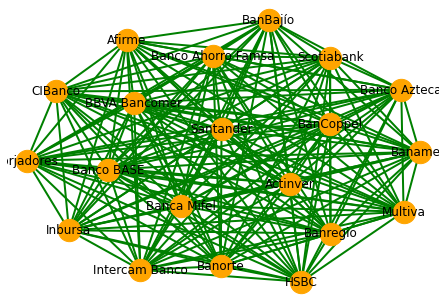

In [51]:
nx.draw(G_banks,  
        
        width=2,
        with_labels=True, 
        node_size=500, 
        node_color='orange',
        edge_color='green')

In [55]:
G_banks = nx.MultiGraph()

In [56]:
def agregar_bancos_municipio(municipio):
    l = df_sucursales[df_sucursales.LLAVE==municipio].DESC_INSTITUCION.to_list()
    edges = [[x[0],x[1]] for x in combinations(l,2)]
    G_banks.add_edges_from(edges)
    

In [57]:
for municipio in aux.LLAVE.unique():
    #print(municipio)
    agregar_bancos_municipio(municipio)
    #break

In [58]:
municipios_solounbanco = ax[ax.NUM_BANCOS_PRESENTES<2].reset_index(drop=True)

In [59]:
nodos_sin_conexiones = municipios_solounbanco.merge(df_sucursales[['DESC_INSTITUCION','LLAVE']])['DESC_INSTITUCION'].drop_duplicates().to_list()

In [60]:
G_banks.add_nodes_from(nodos_sin_conexiones)

In [61]:
G_banks['Barclays']

AdjacencyView({'Banamex': {0: {}}, 'BBVA Bancomer': {0: {}}, 'Santander': {0: {}}, 'HSBC': {0: {}}, 'BanBajío': {0: {}}, 'Inbursa': {0: {}}, 'Banca Mifel': {0: {}}, 'Scotiabank': {0: {}}, 'Bansí': {0: {}}, 'Afirme': {0: {}}, 'Banorte': {0: {}}, 'Bank of America': {0: {}}, 'MUFG Bank México': {0: {}}, 'Monex': {0: {}}, 'Ve por Más': {0: {}}, 'Banco Azteca': {0: {}}, 'Mi Banco BAM': {0: {}}, 'Banco Ahorro Famsa': {0: {}}, 'Multiva': {0: {}}, 'Intercam Banco': {0: {}}, 'BanCoppel': {0: {}}, 'CIBanco': {0: {}}, 'Inmobiliario Mexicano': {0: {}}, 'ICBC México': {0: {}}, 'Banco Shinhan': {0: {}}, 'Bank of China': {0: {}}, 'Banco Keb Hana': {0: {}}})

In [62]:
df_edges = pd.DataFrame(G_banks.edges())

In [63]:
df_edges.rename(columns={0:'A',1:'B'},inplace=True)

In [64]:
df = pd.DataFrame(df_edges.groupby(['A','B']).size())

In [65]:
df = df.reset_index().rename(columns={0:'Mun_relacionan'})

###### Grafo

In [68]:
G_banks = nx.Graph()

In [69]:
G_banks.add_nodes_from(df_sucursales.DESC_INSTITUCION.unique())

In [70]:
##num sucursales
df_numsuc_banco = df_sucursales[['DESC_INSTITUCION','NUM_SUCURSALES']].groupby(['DESC_INSTITUCION'],as_index=False).sum()

In [71]:
for i, banco in df_numsuc_banco.iterrows():
    #print(banco.DESC_INSTITUCION,banco.NUM_SUCURSALES)
    G_banks.nodes[banco.DESC_INSTITUCION]['sucursales'] = banco.NUM_SUCURSALES
    
    #break

In [72]:
##agregar los bancos conectados
G_banks.add_edges_from(df[['A','B']].values)

In [73]:
##agregar peso respecto a el numero de municipios en los que se presentan ambos bancos
for i,edge in df.iterrows():
    #print(edge.A,edge.B)
    G_banks[edge.A][edge.B]['weight'] = edge.Mun_relacionan
    

###### Visualizaciones

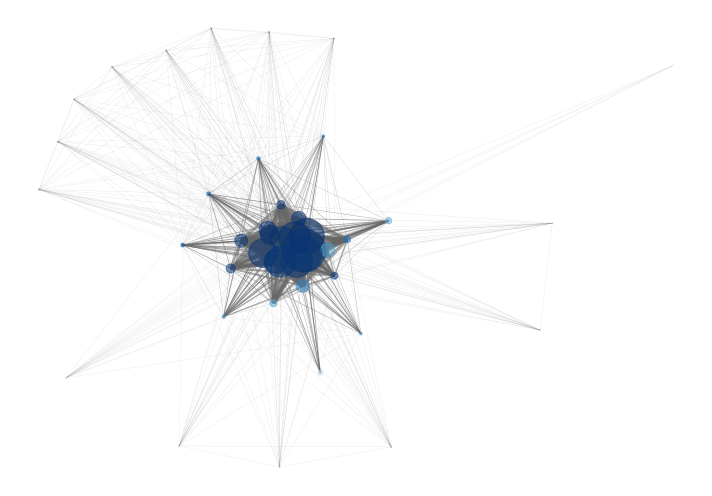

In [76]:
plt.figure(figsize =(10, 7)) 
  
node_color = [G_banks.degree(v) for v in G_banks] 
# node colour is a list of degrees of nodes 
  
node_size = [1 * nx.get_node_attributes(G_banks, 'sucursales')[v] for v in G_banks] 
# size of node is a list of population of cities 
  
edge_width = [0.1 * G_banks[u][v]['weight'] for u, v in G_banks.edges()] 
# width of edge is a list of weight of edges 
  
nx.draw_networkx(G_banks, 
                 node_size = node_size,  
                 node_color = node_color, 
                 alpha = 0.55, 
                 with_labels = False, 
                 width = edge_width, 
                 edge_color ='.4', 
                 cmap = plt.cm.Blues) 
  
plt.axis('off') 
plt.tight_layout(); 

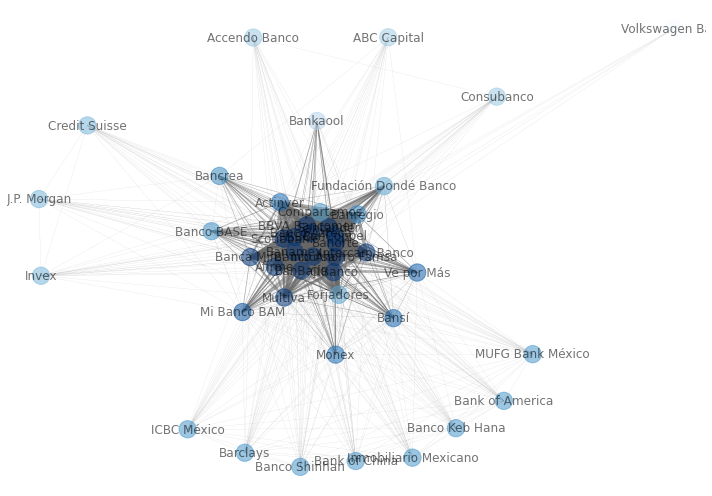

In [77]:
plt.figure(figsize =(10, 7)) 
  
node_color = [G_banks.degree(v) for v in G_banks] 
# node colour is a list of degrees of nodes 
  
#node_size = [1 * nx.get_node_attributes(G_banks, 'sucursales')[v] for v in G_banks] 
# size of node is a list of population of cities 
  
edge_width = [0.1 * G_banks[u][v]['weight'] for u, v in G_banks.edges()] 
# width of edge is a list of weight of edges 
  
nx.draw_networkx(G_banks, 
                 #node_size = node_size,  
                 node_color = node_color, 
                 alpha = 0.55, 
                 with_labels = True, 
                 width = edge_width, 
                 edge_color ='.4', 
                 cmap = plt.cm.Blues) 
  
plt.axis('off') 
plt.tight_layout(); 

### Medidas de centralidad

In [78]:
def sort_dict(x):
    return {k: v for k, v in sorted(x.items(), key=lambda item: item[1],reverse=True)}

In [79]:
sort_dict(nx.degree_centrality(G_banks))

{'Santander': 1.0,
 'Banorte': 1.0,
 'Banco Ahorro Famsa': 1.0,
 'Banamex': 0.9761904761904762,
 'BBVA Bancomer': 0.9761904761904762,
 'HSBC': 0.9761904761904762,
 'BanBajío': 0.9761904761904762,
 'Inbursa': 0.9761904761904762,
 'Scotiabank': 0.9761904761904762,
 'Afirme': 0.9761904761904762,
 'Banco Azteca': 0.9761904761904762,
 'Intercam Banco': 0.9761904761904762,
 'BanCoppel': 0.9761904761904762,
 'CIBanco': 0.9761904761904762,
 'Banca Mifel': 0.9523809523809523,
 'Multiva': 0.9523809523809523,
 'Mi Banco BAM': 0.8809523809523809,
 'Ve por Más': 0.8333333333333333,
 'Bansí': 0.8095238095238095,
 'Monex': 0.7857142857142857,
 'Actinver': 0.7857142857142857,
 'Banregio': 0.7142857142857142,
 'Bancrea': 0.6904761904761905,
 'Banco BASE': 0.6666666666666666,
 'Bank of America': 0.6428571428571428,
 'MUFG Bank México': 0.6428571428571428,
 'Barclays': 0.6428571428571428,
 'Inmobiliario Mexicano': 0.6428571428571428,
 'ICBC México': 0.6428571428571428,
 'Banco Shinhan': 0.642857142857142

In [80]:
sort_dict(nx.betweenness_centrality(G_banks))

{'Santander': 0.021269074453344305,
 'Banorte': 0.021269074453344305,
 'Banco Ahorro Famsa': 0.021269074453344305,
 'Banco Azteca': 0.019232067238534267,
 'BanCoppel': 0.019232067238534267,
 'Banamex': 0.012519558386755072,
 'BBVA Bancomer': 0.012519558386755072,
 'HSBC': 0.012519558386755072,
 'BanBajío': 0.012519558386755072,
 'Inbursa': 0.012519558386755072,
 'Scotiabank': 0.012519558386755072,
 'Afirme': 0.012519558386755072,
 'Intercam Banco': 0.012519558386755072,
 'CIBanco': 0.012519558386755072,
 'Banca Mifel': 0.010596960079139347,
 'Multiva': 0.010596960079139347,
 'Mi Banco BAM': 0.006297259168964975,
 'Actinver': 0.005158839173952281,
 'Ve por Más': 0.004623678597098517,
 'Bansí': 0.003419728182244229,
 'Banregio': 0.003061010311983872,
 'Monex': 0.0028842431281455665,
 'Bancrea': 0.0018348887122956444,
 'Banco BASE': 0.0011512521140248997,
 'Compartamos': 0.000143244289585753,
 'Forjadores': 4.645760743321719e-05,
 'Fundación Dondé Banco': 4.645760743321719e-05,
 'Invex': 

In [81]:
sort_dict(nx.pagerank(G_banks))

{'Banco Azteca': 0.07778072364825539,
 'BanCoppel': 0.07371945189163986,
 'BBVA Bancomer': 0.0705924355520857,
 'Banorte': 0.06373385416939335,
 'Santander': 0.06267756264251523,
 'HSBC': 0.06253689750041849,
 'Banamex': 0.05765620480668895,
 'Scotiabank': 0.05234439694603631,
 'Inbursa': 0.04976465321577239,
 'Banco Ahorro Famsa': 0.04694416802316633,
 'BanBajío': 0.03999002505809787,
 'Compartamos': 0.036572149695889886,
 'CIBanco': 0.03333755460299959,
 'Afirme': 0.027361755776984433,
 'Intercam Banco': 0.02398858885601694,
 'Banregio': 0.022666210260580202,
 'Actinver': 0.01891564136035397,
 'Banca Mifel': 0.018287482537273764,
 'Multiva': 0.01581721384922396,
 'Forjadores': 0.013300810527875077,
 'Mi Banco BAM': 0.009252743238939544,
 'Ve por Más': 0.009206124248855288,
 'Banco BASE': 0.008294465760705697,
 'Fundación Dondé Banco': 0.008232441344453202,
 'Bansí': 0.008163429743849478,
 'Monex': 0.006911018333914943,
 'Bancrea': 0.006739126755696342,
 'Inmobiliario Mexicano': 0.005

In [82]:
sort_dict(nx.closeness_centrality(G_banks))

{'Santander': 1.0,
 'Banorte': 1.0,
 'Banco Ahorro Famsa': 1.0,
 'Banamex': 0.9767441860465116,
 'BBVA Bancomer': 0.9767441860465116,
 'HSBC': 0.9767441860465116,
 'BanBajío': 0.9767441860465116,
 'Inbursa': 0.9767441860465116,
 'Scotiabank': 0.9767441860465116,
 'Afirme': 0.9767441860465116,
 'Banco Azteca': 0.9767441860465116,
 'Intercam Banco': 0.9767441860465116,
 'BanCoppel': 0.9767441860465116,
 'CIBanco': 0.9767441860465116,
 'Banca Mifel': 0.9545454545454546,
 'Multiva': 0.9545454545454546,
 'Mi Banco BAM': 0.8936170212765957,
 'Ve por Más': 0.8571428571428571,
 'Bansí': 0.84,
 'Monex': 0.8235294117647058,
 'Actinver': 0.8235294117647058,
 'Banregio': 0.7777777777777778,
 'Bancrea': 0.7636363636363637,
 'Banco BASE': 0.75,
 'Bank of America': 0.7368421052631579,
 'MUFG Bank México': 0.7368421052631579,
 'Barclays': 0.7368421052631579,
 'Inmobiliario Mexicano': 0.7368421052631579,
 'ICBC México': 0.7368421052631579,
 'Banco Shinhan': 0.7368421052631579,
 'Bank of China': 0.73684